In [1]:
import sys
import pickle 

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
from Functions import renormalize, scomplex, plotting
import matplotlib.pyplot as plt
import networkx as nx

import xgi
from itertools import combinations, product
from tqdm import tqdm
import seaborn as sns
plt.rcParams["text.usetex"] = False


colors = ["#003F5C","#2F4B7C","#665191","#A05195","#D45087","#F95D6A","#FF7C43","#FFA600"]
colors_sequential = colors + colors + colors + colors 
colors = ["#02405c", "#fea600", "#a20655", "#5e96c5", "#4b3596", "#fa6ca9", "#8d6cf6"]
colors_curves = colors+ colors+ colors+ colors


### Functions

In [3]:
def adjacency_of_order_hg(sc,k,l):
    # sc: hypergraph object
    # k: order of the diffusing simplices
    # l: order of the interaction simplices

    keys = ["nodes", "edges", "faces", "tetrahedra", "4-simplices"]
    nk = sc[f"n{k}"]
    adj = np.zeros((nk,nk),dtype = int)

    if l < k: 
       
        diff_units = sc[keys[k]]
        
        if l == 0:
            for i in range(nk):
                for j in range(i+1,nk):
                    intersection = (set(diff_units[i,:]) & set(diff_units[j,:]))
                    adj[i,j] = 2*len(intersection)
                    
        else: 
            edge_dict, face_dict, tet_dict = scomplex.make_dict(sc)
            dicts = [{(i,):i for i in range(sc["n0"])},edge_dict,face_dict,tet_dict]
            for i in range(nk):
                for j in range(i+1,nk):
                    intersection = (set(diff_units[i,:]) & set(diff_units[j,:]))
                    combs = list(combinations(intersection, l+1))
                    for c in combs:
                        if c in dicts[l]:
                            adj[i,j] += 2
                

    elif l > k:
        edge_dict, face_dict, tet_dict = scomplex.make_dict(sc)
        dicts = [{(i,):i for i in range(sc["n0"])},edge_dict,face_dict,tet_dict]
        for i,simp in enumerate(sc[keys[l]]):
            combs = list(combinations(simp, k+1))
            ncombs = len(combs)
            combs_present = []
            for c in range(ncombs):
                if combs[c] in dicts[k]:
                    combs_present.append(dicts[k][combs[c]])

            for c1 in combs_present:
                for c2 in combs_present:
                    if c2 != c1:
                        adj[c1,c2] += 1

    return (adj + adj.T)//2

def XO_laplacian_hg(sc,k,l):
    A = adjacency_of_order_hg(sc,k,l)
    K = np.sum(A, 0)
    L = np.diag(K) - A
    return L

In [5]:

def induce_simplices_hg(sc, mapnodes):
    # Finds induced simplices in the simplicial complex after its nodes are coarse grained 
    # INPUTS
    # sc: simplicial complex object
    # mapnodes: mapping from each node in sc to the label of its signature
  
    # OUTPUTS
    # new_sc: coarse grained simplicial complex object

    keys = ["edges", "faces", "tetrahedra", "4-simplices"]
    new_sc = {
        "nodes": np.sort(np.unique(mapnodes)),
    }
    new_sc["n0"] = len(new_sc["nodes"])
    new_sc["nodes"] = np.reshape(new_sc["nodes"], (new_sc["n0"], 1))
    for key in keys:
        new_sc[key] = []

    # Connect supernodes with hyperedges
    for order, key in enumerate(keys):
        for i in range(sc[f"n{order+1}"]):
            nodes = mapnodes[sc[key][i, :]]
            un = np.unique(nodes)
            lun = len(un)
            if lun > 1:
                new_sc[keys[lun-2]].append(un)

    # Remove duplicate hyperedges
    for order, key in enumerate(keys):
        if len(new_sc[key]) != 0:
            new_sc[key] = np.unique(
                np.sort(np.array(new_sc[key], dtype=int), axis=1), axis=0
            )
            new_sc[f"n{order+1}"] = new_sc[key].shape[0]
        else:
            new_sc[key] = np.zeros((0, order+2), dtype=int)
            new_sc[f"n{order+1}"] = 0

    return new_sc

def renormalize_single_step_hg(sc,tau, diff_order =0, int_order = 1, D = None, U = None, VERBOSE = True):
    # Performs a single step of higher-order Laplacian renormalization 
    # INPUTS
    # sc: simplicial complex object
    # tau: diffusion time
    # diff_order: order of the diffusing simplices
    # int_order: order of the interaction simplices
    # D: the list of Laplacian eigenvlaues, if None computes them from scratch
    # U: the list of Laplacian eigenvectors, if None computes them from scratch 
    # VERBOSE: if True print the number of nodes after the coarse-graining

    # OUTPUTS
    # new_sc: renormalized simplicial complex
    # mapnodes: array associating to each node in sc the node in new_sc it is mapped to
    # clusters: cluster label of each simplex of order diff_order
  

    if (D is None) or (U is None):
        L = XO_laplacian_hg(sc, diff_order, int_order)
        D,U = np.linalg.eigh(L)

    rho  = np.abs(U@np.diag(np.exp(-tau*D))@U.T)

    Gv = nx.Graph()
    Gv.add_nodes_from([i for i in range(sc[f"n{diff_order}"])])
    for i in range(sc[f"n{diff_order}"]):
        for j in range(i+1,sc[f"n{diff_order}"]):
            if rho[i,j] >= min(rho[i,i],rho[j,j]):
                Gv.add_edge(i,j)

        
    idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
    clusters = [idx_components[u] for u in Gv.nodes]

    mapnodes,__ = renormalize.coarse_grain(sc,diff_order,clusters,np.max(clusters)+1)
    new_sc = induce_simplices_hg(sc, mapnodes)

    if VERBOSE:
        print(new_sc["n0"])

        
    return new_sc, mapnodes, clusters  


In [6]:
def hg_to_sc(H):
    H.cleanup()

    sc = {}
    sc["nodes"] = np.sort(np.array([H.nodes]).T,0)
    sc["n0"] = sc["nodes"].shape[0]
    keys = ["edges","faces","tetrahedra","4-simplices"]

    for k in keys:
        sc[k] = []
    for e in H.edges.members():
        if len(e) <= 5:
            sc[keys[len(e)-2]].append(list(e))

    for i,k in enumerate(keys):
        if len(sc[k]) == 0:
            sc[k] = np.zeros((0,i+2))
        else:
            sc[k] = np.unique(np.sort(np.array(sc[k]),1),axis =0)
        
        sc[f"n{i+1}"] = sc[k].shape[0] 
    return sc

In [7]:
def laplacians(dim = 2):
    if dim == 4:
        laps = ["01","02","03","04","10","12","13","14","20","21","23","24","30","31","32","34","40","41","42","43"]
    elif dim == 3:
        laps = ["01","02","03","10","12","13","20","21","23","30","31","32"]
    elif dim == 2:
        laps = ["01","02","10","12","20","21"]
    elif dim == 1:
        laps = ["01","10"]
    return laps

# XGI Hypergraphs test

In [2]:
#Load the data
#xgi.load_xgi_data()

#select hypergraph with max HOI = 5 nodes
names_hg = ['congress-bills', 'contact-high-school', 'contact-primary-school', 'diseasome', 'disgenenet','email-enron', 'email-eu', 'hospital-lyon', 'house-bills', 'house-committees', 'hypertext-conference', 'invs13', 'invs15','kaggle-whats-cooking', 'malawi-village','ndc-classes', 'ndc-substances', 'science-gallery', 'senate-bills', 'senate-committees','sfhh-conference']
true_names_hg = ['US Congress Bills', 'High school contacts', 'Primary school contact', 'Diseasome', 'Disgenenet', 'Enron email', 'Eu email', 'Hospital contacts', 'House bills', 'House committees', 'Hypertext contacts', 'InVS13', 'InVS15', 'Kaggle Competition', 'Malawi contacts', 'Classes of NDC', 'Substances of NDC', 'Science Gallery', 'Senate bills', 'Senate committees', 'SFHH conference']

In [94]:
# Define the hypergraphs and convert to our format
HGs = {}
scs = {}
for name in tqdm(data_names):
    HGs[name] = xgi.load_xgi_data(name, max_order=5, cache=True)
    HGs[name].cleanup(connected = True)
    scs[name] = hg_to_sc(HGs[name])

100%|██████████| 21/21 [01:04<00:00,  3.05s/it]


Save/Import hypergraphs

In [29]:
#xgi datasets
save = False
if save == True:
    #save the hypergraphs
    with open("../Experiments_results/xgi/xgi_sc.pkl", "wb") as f:
        pickle.dump(scs, f)
else:
    #import the hypergraphs in our format
    with open("../Experiments_results/xgi/xgi_sc.pkl", "rb") as f:
        scs = pickle.load(f)

## Compute Laplacians an Sp Heats

In [8]:
N_data = len(names_hg)
print('Number of datasets =', N_data)

Number of datasets = 21


In [11]:
# Select dataset
i = 0
name = data_names[i]
sc = scs[name]
smax = 0
for i in range(5):
    if sc[f'n{i}'] != 0:
        smax +=1
print(name, smax)
print('Nodes', sc["n0"], 'Edges', sc["n1"], 'Faces', sc["n2"],  'Tetrahedra', sc["n3"], '4-simplices', sc["n4"])

congress-bills 5
Nodes 1718 Edges 13871 Faces 10156 Tetrahedra 7764 4-simplices 5780


In [12]:
NULL_MODEL = True
nrep = 3
if NULL_MODEL:
    G = nx.from_edgelist(sc["edges"])

sparse = False
num_eigs = 500

# Define strings which specify the cross-order Laplacians to consider
laplacians_types = laplacians(smax - 1)

C_curves = []
taumin = -3 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval

if NULL_MODEL:
    for idl,l in enumerate(laplacians_types): 
        print(l)
        C_curves.append([])
        A = adjacency_of_order_hg(sc, k=int(l[0]), l=int(l[1]))
        for n in tqdm(range(nrep)):
            # # Configuration model
            Gcm = nx.Graph(A)
            Gcm = nx.configuration_model([val for (__, val) in Gcm.degree()])
            L = XO_laplacian_hg(sc, k=int(l[0]), l=int(l[1]))
            
            if sparse:
                D,__ = scipy.sparse.linalg.eigsh(L.asfptype(),k = num_eigs, which = "SM")
                D = np.append(D,1000000*np.ones(L.shape[0]-num_eigs),axis=0)
            else:
                D,__ = np.linalg.eigh(L)
                D = np.abs(D)
            entropic_susceptibility,tau_space,__  = renormalize.compute_entropic_C(D,taumin,taumax,ntau)
            C_curves[l] = entropic_susceptibility


else:
    for idl,l in enumerate(laplacians_types):    
        print(l) 
        ## Configuration model
        L = XO_laplacian_hg(sc, k=int(l[0]), l=int(l[1]))
        
        if sparse:
            D,__ = scipy.sparse.linalg.eigsh(L.asfptype(),k = num_eigs, which = "SM")
            D = np.append(D,1000000*np.ones(L.shape[0]-num_eigs),axis=0)
        else:
            D,__ = np.linalg.eigh(L)
            D = np.abs(D)
        entropic_susceptibility,tau_space,__  = renormalize.compute_entropic_C(D,taumin,taumax,ntau)
        C_curves[l] = entropic_susceptibility


01


  0%|          | 0/3 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/martamorandini/Desktop/projects/Simplicial_Renormalization/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:28: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
100%|██████████| 3/3 [00:32<00:00, 10.68s/it]


02


100%|██████████| 3/3 [00:36<00:00, 12.07s/it]


03


100%|██████████| 3/3 [00:34<00:00, 11.47s/it]


04


100%|██████████| 3/3 [00:28<00:00,  9.58s/it]


10


100%|██████████| 3/3 [1:25:02<00:00, 1700.83s/it]


12


100%|██████████| 3/3 [1:08:40<00:00, 1373.57s/it]


13


100%|██████████| 3/3 [53:14<00:00, 1064.76s/it]


14


  0%|          | 0/3 [00:00<?, ?it/s]

Save/Import specific heats curves

In [49]:
#save the specific heats
save = False
NULL_MODEL = True

path = f"../Experiments_results/xgi/xgi_spheats"
path = path + '.pkl' if NULL_MODEL == False else path + '_cm.pkl'
if save == True:
    with open(path, "wb") as f:
        pickle.dump(C_curves, f)
else:
    with open(path, "rb") as f:
        C_curves = pickle.load(f)

Plot the specific heats

(array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 [Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

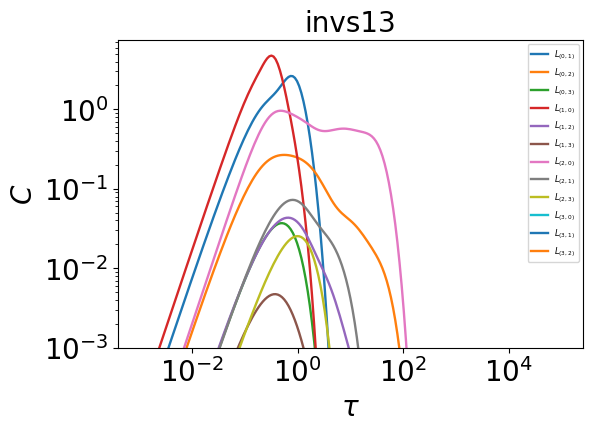

In [61]:
#select the data
name = 'invs13'
sp_heats = C_curves[name]
laplacians_types = list(sp_heats.keys())

taumin = -3 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval
tau_space = np.logspace(taumin, taumax, num=ntau-1)

cols  = sns.color_palette("colorblind", len(laplacians_types))
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))

if NULL_MODEL == True:
    for i, l in enumerate(laplacians_types):
        av_sp_heats = np.mean(sp_heats[l], axis = 0)
        ax.loglog(tau_space,av_sp_heats,linewidth = 1.7,alpha = 1)
else:
    for i, l in enumerate(laplacians_types):
        ax.loglog(tau_space,sp_heats[l],linewidth = 1.7,alpha = 1)


ax.set_ylim([10**-3,7.5])
#ax.set_xlim([10**taumin,10**4])

ax.legend([names[i] for i in range(len(laplacians_types))],fontsize = 6)
plt.title(f"{name}",fontsize = 20)

ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#plt.savefig('../.pdf', bbox_inches = 'tight')

In [233]:
cols = colors_curves
for name in data_names:
    sp_heats = sph[name]
    smax = 0
    for i in range(5):
        if sc[f'n{i}'] != 0:
            smax +=1
    laplacians_types = laplacians(dim = smax - 1)

    names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]

    #compute the SIP for all the laplacians
    measure = {l : 0 for l in laplacians_types}
    for i, l in enumerate(laplacians_types):
        measure[l] = renormalize.measure_SI(tau_space,sp_heats[i], epsilon=0.15, ymin = -3, ymax = 3, ny = ntau)
    print(measure)
    SIP[name] = measure

{'01': 1.5736259932019672, '02': 1.5736259932019672, '03': 1.8513246978846674, '04': 1.758758462990434, '10': 1.1107948187308003, '12': 0.0, '13': 0.0, '14': 0.0, '20': 0.6479636442596336, '21': 0.0, '23': 0.0, '24': 0.0, '30': 0.5553974093654002, '31': 0.0, '32': 0.0, '34': 0.0, '40': 0.5553974093654002, '41': 0.0, '42': 0.0, '43': 0.0}
{'01': 1.3884935234135005, '02': 1.5736259932019672, '03': 1.4810597583077338, '04': 1.8513246978846674, '10': 0.6479636442596336, '12': 0.0, '13': 0.0, '14': 0.0, '20': 0.46283117447116684, '21': 0.0, '23': 0.0, '24': 0.0, '30': 0.46283117447116684, '31': 0.0, '32': 0.0, '34': 0.0, '40': 0.46283117447116684, '41': 0.0, '42': 0.0, '43': 0.0}
{'01': 0.6479636442596336, '02': 1.018228583836567, '03': 1.1107948187308003, '04': 1.1107948187308003, '10': 0.46283117447116684, '12': 0.0, '13': 1.2959272885192672, '14': 1.2959272885192672, '20': 0.37026493957693346, '21': 0.0, '23': 0.0, '24': 0.0, '30': 0.37026493957693346, '31': 1.1107948187308003, '32': 0.0

/Users/martamorandini/Desktop/projects/Simplicial_Renormalization/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: divide by zero encountered in log
  sp_heat =  np.log(sp_heat)
/Users/martamorandini/Desktop/projects/Simplicial_Renormalization/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: invalid value encountered in log
  sp_heat =  np.log(sp_heat)


In [ ]:

    #select the n- Laplacians with the highest measure
    highest = 5
    values = np.array(list(measure.values()))
    #whats the fifth highest value
    threshold = np.partition(values, -highest)[-highest]
    selected_laplacians = {l:measure[l] for l in laplacians_types if (measure[l] >= threshold) & (measure[l] != 0)}
    #selected_laplacians

In [234]:
#save SIP_cl
with open(f"../Experiments_results/xgi/SIP_cl.pkl", "wb") as f:
    pickle.dump(SIP_cl, f)

Text(0.5, 1.0, 'contact-primary-school')

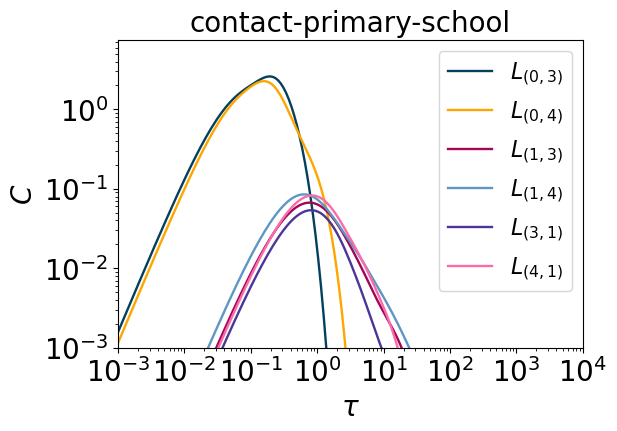

In [161]:

f,ax = plt.subplots(1,1,figsize = (6,4))
selected_names = [names[laplacians_types.index(k)] for k in selected_laplacians.keys()]
for i, l in enumerate(selected_laplacians.keys()):
    i_l = laplacians_types.index(l)
    ax.loglog(tau_space,sp_heats[i_l],linewidth = 1.7,alpha = 1, color = cols[i])


ax.set_ylim([10**-3,7.5])
ax.set_xlim([10**-3,10**4])

ax.legend(selected_names,fontsize = 16)


ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title(f"{name}",fontsize = 20)
#ax.vlines(x = 4,ymin = 10**-1,ymax = 0.9,linestyles="--",color = [0.5,0.5,0.5])

#plt.savefig(f"../C_curves/xgi/{name}_best_spheats.pdf",bbox_inches = "tight")

## SIP

In [81]:
SIP = {name: {} for name in data_names}
for name in data_names:
    with open(f"../Experiments_results/xgi/{name}_spheats.pkl", "rb") as f:
        sp_heats = pickle.load(f)
    with open("../Experiments_results/xgi/xgi_sc.pkl", "rb") as f:
        scs = pickle.load(f)
    sc = scs[name]
    smax = 0
    for i in range(5):
        if sc[f'n{i}'] != 0:
            smax +=1
    print(name, smax)
    print('Nodes', sc["n0"], 'Edges', sc["n1"], 'Faces', sc["n2"],  'Tetrahedra', sc["n3"], '4-simplices', sc["n4"])

    laplacians_types = laplacians(dim = smax - 1)
    ymin, ymax, ny = -3, 5, 200

    measure = {l : 0 for l in laplacians_types}
    for i, l in enumerate(laplacians_types):
        measure[l] = renormalize.measure_SI(tau_space,sp_heats[i], epsilon=0.15, ymin = ymin, ymax = ymax, ny = ny)
    SIP[name] = measure


congress-bills 5
Nodes 1718 Edges 13871 Faces 10156 Tetrahedra 7764 4-simplices 5780
contact-high-school 5
Nodes 327 Edges 5498 Faces 2091 Tetrahedra 222 4-simplices 7
contact-primary-school 5
Nodes 242 Edges 7748 Faces 4600 Tetrahedra 347 4-simplices 9
diseasome 5
Nodes 516 Edges 153 Faces 92 Tetrahedra 26 4-simplices 25
disgenenet 5
Nodes 12368 Edges 157 Faces 139 Tetrahedra 93 4-simplices 66
email-enron 5
Nodes 143 Edges 809 Faces 317 Tetrahedra 138 4-simplices 63
email-eu 5
Nodes 986 Edges 12753 Faces 4938 Tetrahedra 2294 4-simplices 1359
hospital-lyon 5
Nodes 75 Edges 1107 Faces 657 Tetrahedra 58 4-simplices 2
house-bills 5
Nodes 1494 Edges 7656 Faces 4369 Tetrahedra 3350 4-simplices 2607


/Users/martamorandini/Desktop/projects/Simplicial_Renormalization/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: divide by zero encountered in log
  sp_heat =  np.log(sp_heat)
/Users/martamorandini/Desktop/projects/Simplicial_Renormalization/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: invalid value encountered in log
  sp_heat =  np.log(sp_heat)


house-committees 5
Nodes 1290 Edges 1 Faces 2 Tetrahedra 11 4-simplices 25
hypertext-conference 5
Nodes 113 Edges 2103 Faces 302 Tetrahedra 18 4-simplices 7
invs13 4
Nodes 92 Edges 741 Faces 44 Tetrahedra 2 4-simplices 0
invs15 4
Nodes 217 Edges 4142 Faces 755 Tetrahedra 12 4-simplices 0
kaggle-whats-cooking 5
Nodes 6714 Edges 177 Faces 527 Tetrahedra 1095 4-simplices 1858
malawi-village 4
Nodes 84 Edges 341 Faces 86 Tetrahedra 4 4-simplices 0
ndc-classes 5
Nodes 628 Edges 135 Faces 92 Tetrahedra 100 4-simplices 73
ndc-substances 5
Nodes 3414 Edges 1027 Faces 717 Tetrahedra 516 4-simplices 498
science-gallery 5
Nodes 410 Edges 2491 Faces 808 Tetrahedra 46 4-simplices 5
senate-bills 5
Nodes 294 Edges 3280 Faces 3013 Tetrahedra 2394 4-simplices 1685
senate-committees 3
Nodes 282 Edges 0 Faces 0 Tetrahedra 9 4-simplices 22
sfhh-conference 5
Nodes 403 Edges 8268 Faces 1861 Tetrahedra 258 4-simplices 63


### save/import

In [346]:
#save SIP
with open(f"../Experiments_results/xgi/SIP.pkl", "wb") as f:
    pickle.dump(SIP, f)

In [8]:
#import SIP
with open(f"../Experiments_results/xgi/SIP.pkl", "rb") as f:
    SIP = pickle.load(f)

## plot sip

In [242]:
def plot_polar_sip(sip, sip_nm, name, true_name, color = colors_curves[0], size = (4, 4), ncol = 1, nrow = 1, idx = 0):
    plt.figure(figsize = size)
    ax = plt.subplot(ncol, nrow,idx+1, polar=True)
    lap = list(sip.keys())

    angles = np.mod(np.pi/2 + np.linspace(0, 2*np.pi, len(lap), endpoint=False),2*np.pi)
        #stats = [s for s in sip.values() if s != 0]
    stats = list(sip.values())
    stats = np.concatenate((stats,[stats[0]]))
    stats_nm = list(sip_nm.values())
    stats_nm = np.concatenate((stats_nm, [stats_nm[0]]))
    M =round( (max(max(stats), max(stats_nm))) + 0.6)

    angles = np.concatenate((angles,[angles[0]]))
    ax.plot(angles, stats_nm, 'o-', linewidth=2,color = 'grey')
    ax.fill(angles, stats_nm, alpha=0.2,color = 'grey')
    ax.plot(angles, stats, 'o-', linewidth=2,color = colors_curves[0])
    ax.fill(angles, stats, alpha=0.2,color = colors_curves[0])
    

    ax.set_xticks(angles,[f"${{({l[0]},{l[1]})}}$" for l in lap+[lap[0]]],fontsize = 12)
        #ax.tick_paras(axis='x', which='major', pad=13)
    ax.grid(linewidth=0.6,linestyle = '--')
    ax.set_rmax(M)
    ax.set_rticks([l for l in np.arange(0.5, M, 0.5)])
    ax.set_rlabel_position(-90)
        #ax.set_rlabel_position(-90)  # Move radial labels away from plotted line

    ax.set_title(true_names[data_names.index(name)], fontsize = 18)
    plt.show()
    return ax

congress-bills
20
contact-high-school
20
contact-primary-school
20
diseasome
20
disgenenet
20
email-enron
20
email-eu
20
hospital-lyon
20
house-bills
20
house-committees
20
hypertext-conference
20
invs13
20
invs15
20
kaggle-whats-cooking
20
malawi-village
20
ndc-classes
20
ndc-substances
20
science-gallery
20
senate-bills
20
senate-committees
20
sfhh-conference
20


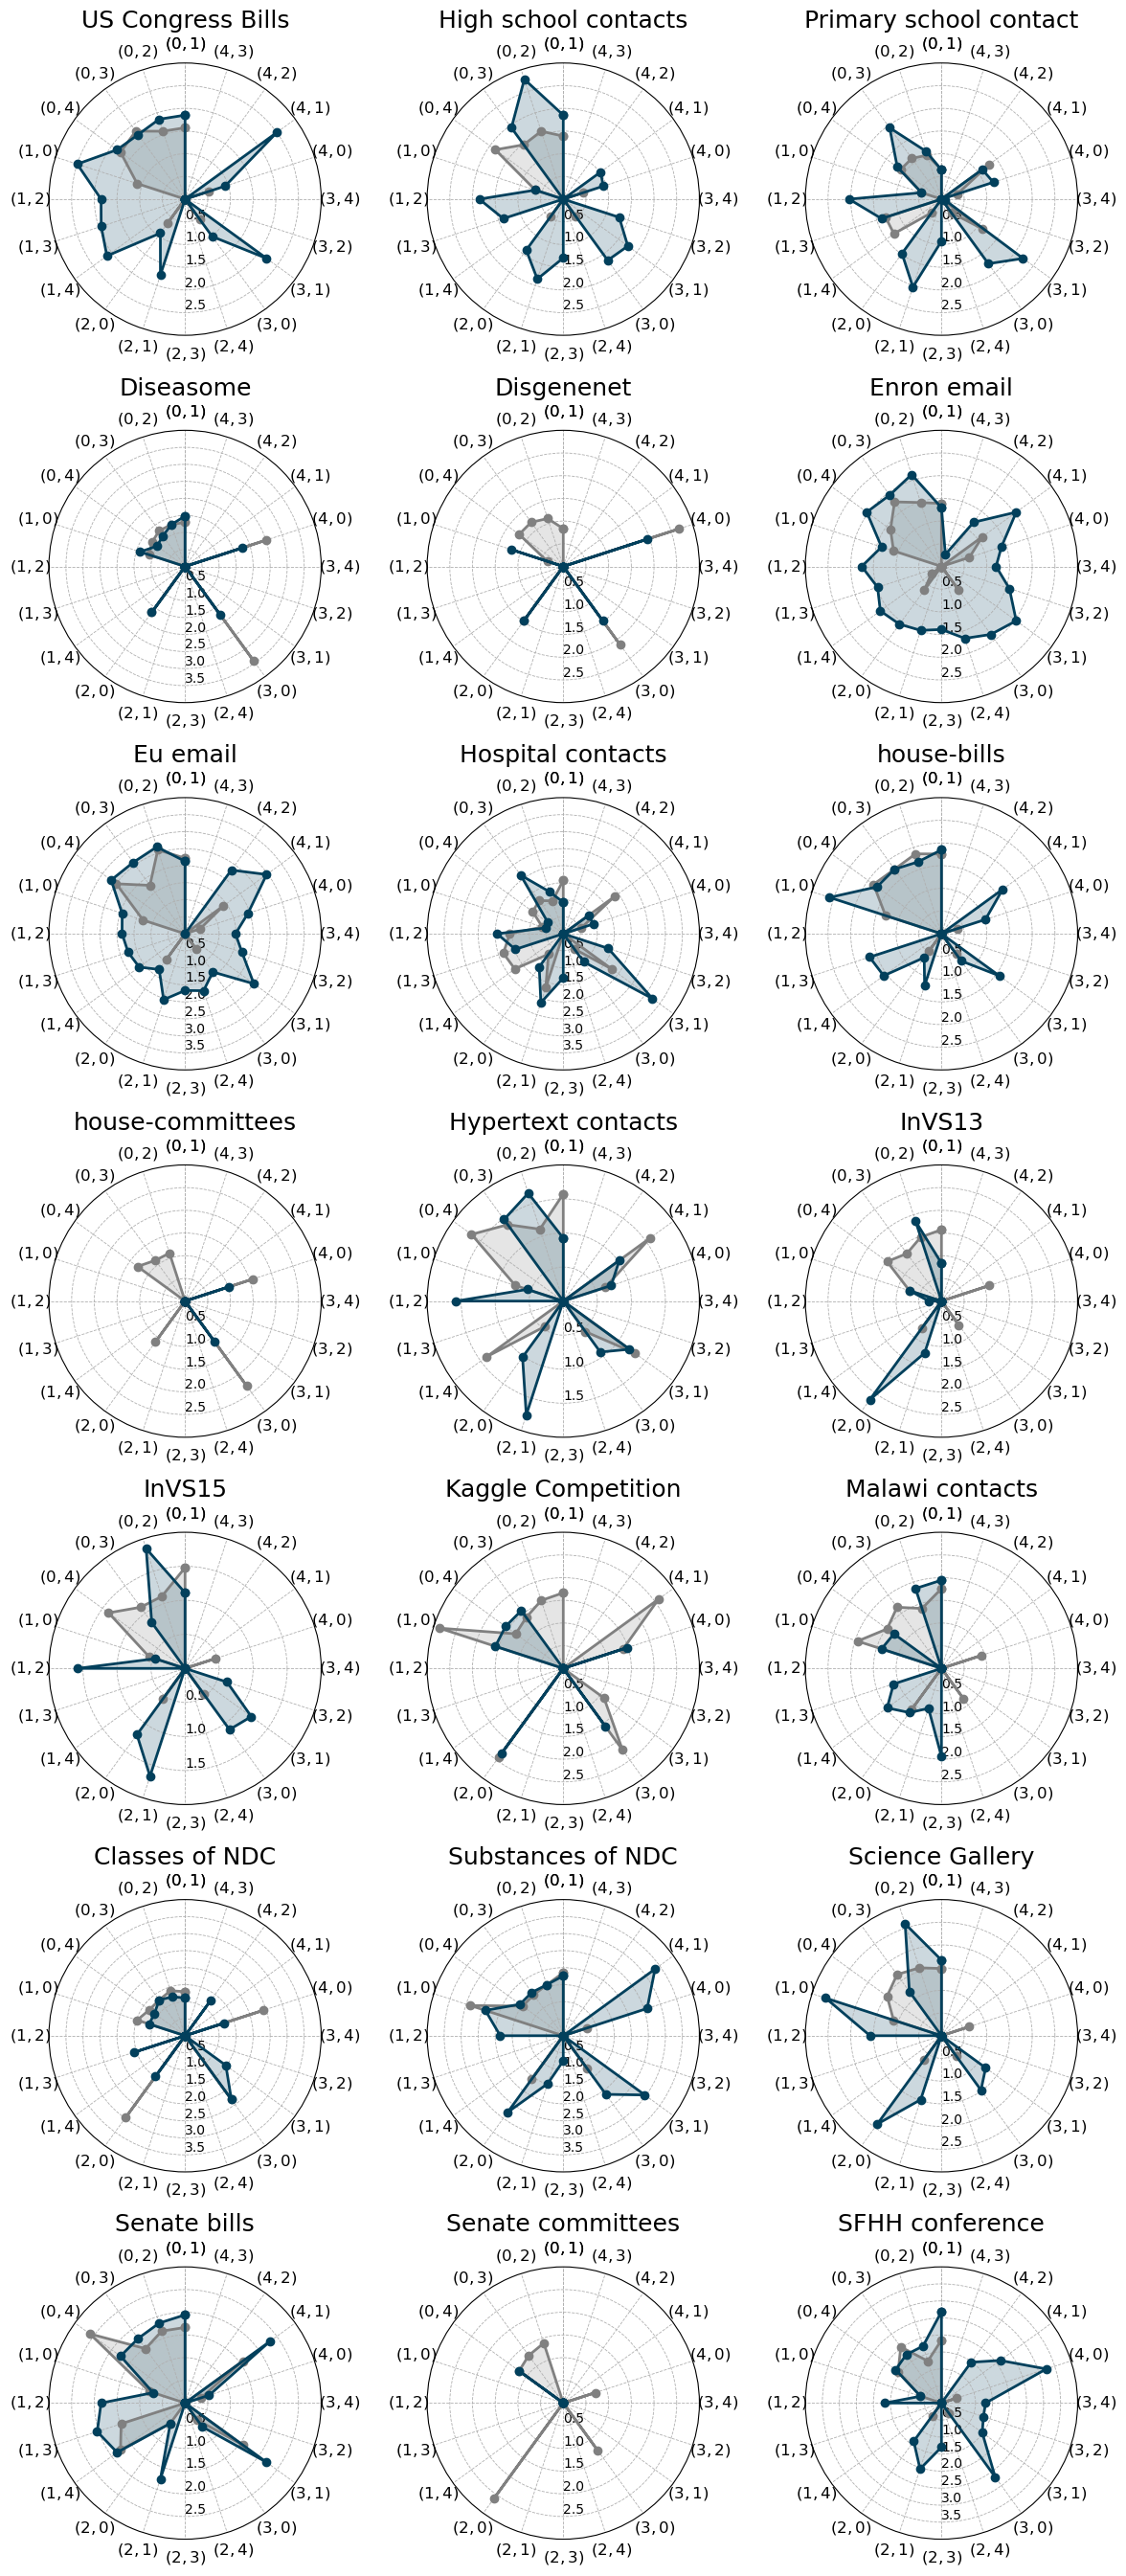

In [383]:
#polar plot of the SIP for one dataset
idx = 0
plt.figure(figsize = (12,27))
for name in data_names:
    print(name)
    sip = SIP[name]
    sip_cl = SIP_cl[name]
    lap = list(sip_cl.keys())
    ax = plt.subplot(7,3,idx+1, polar=True)
    print(len(lap))
    angles = np.mod(np.pi/2 + np.linspace(0, 2*np.pi, len(lap), endpoint=False),2*np.pi)
    stats = list(sip.values())
    stats_nm = list(sip_cl.values())
    M =round( (max(max(stats), max(stats_nm))) + 0.6)
    
    angles = np.concatenate((angles,[angles[0]]))

    stats = np.concatenate((stats,[stats[0]]))
    stats_nm = np.concatenate((stats_nm, [stats_nm[0]]))


    if len(stats) != len(stats_nm):
        print(len(stats), len(stats_nm))


    ax.plot(angles, stats_nm, 'o-', linewidth=2,color = 'grey')
    ax.fill(angles, stats_nm, alpha=0.2,color = 'grey')

    ax.plot(angles, stats, 'o-', linewidth=2,color = colors_curves[0])
    ax.fill(angles, stats, alpha=0.2,color = colors_curves[0])

    ax.set_xticks(angles,[f"${{({l[0]},{l[1]})}}$" for l in lap+[lap[0]]],fontsize = 12)
    #ax.tick_params(axis='x', which='major', pad=13)
    ax.grid(linewidth=0.6,linestyle = '--')
    ax.set_rmax(M)
    ax.set_rticks([l for l in np.arange(0.5, M, 0.5)])
    ax.set_rlabel_position(-90)
    #ax.set_rlabel_position(-90)  # Move radial labels away from plotted line

    ax.set_title(true_names[data_names.index(name)], fontsize = 18)
    idx+=1
plt.tight_layout()


plt.savefig('../C_Curves/xgi/SIP.pdf',bbox_inches = "tight")


# Watts-Strogatz hypergraph

In [208]:
from networkx.utils import py_random_state
@py_random_state(3)
#generate a hypergraph with n nodes, k nearest neighbors, and rewiring probability p
#the code in made for maxdim = 2
#each time an edge is rewired, it is replaced by an empty triangle and each edge of this triangle has probability 0.5 of exists
def watts_strogatz_hypergraph(n, k, p, seed=None, p_triangle = 0.5, p_edge = 0.2):
    """Returns a Watts–Strogatz small-world hypergraph.

    Parameters
    ----------
    n : int
        The number of nodes
    k : int
        Each node is joined with its `k` nearest neighbors in a ring
        topology.
    p : float
        The probability of rewiring each edge
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    See Also
    --------
    newman_watts_strogatz_graph
    connected_watts_strogatz_graph

    Notes
    -----
    First create a ring over $n$ nodes [1]_.  Then each node in the ring is joined
    to its $k$ nearest neighbors (or $k - 1$ neighbors if $k$ is odd).
    Then shortcuts are created by replacing some edges as follows: for each
    edge $(u, v)$ in the underlying "$n$-ring with $k$ nearest neighbors"
    with probability $p$ replace it with a new edge $(u, w)$ with uniformly
    random choice of existing node $w$.

    In contrast with :func:`newman_watts_strogatz_graph`, the random rewiring
    does not increase the number of edges. The rewired graph is not guaranteed
    to be connected as in :func:`connected_watts_strogatz_graph`.

    References
    ----------
    .. [1] Duncan J. Watts and Steven H. Strogatz,
       Collective dynamics of small-world networks,
       Nature, 393, pp. 440--442, 1998.
    """
    if k > n:
        raise nx.NetworkXError("k>n, choose smaller k or larger n")

    # If k == n, the graph is complete not Watts-Strogatz
    if k == n:
        return nx.complete_graph(n)

    G = nx.Graph()
    nodes = list(range(n))  # nodes are labeled 0 to n-1
    # connect each node to k/2 neighbors
    for j in range(1, k // 2 + 1):
        targets = nodes[j:] + nodes[0:j]  # first j nodes are now last in list
        G.add_edges_from(zip(nodes, targets))
    # rewire edges from each node
    # loop over all nodes in order (label) and neighbors in order (distance)
    # no self loops or multiple edges allowed
    faces = []
    for j in range(1, k // 2 + 1):  # outer loop is neighbors
        targets = nodes[j:] + nodes[0:j]  # first j nodes are now last in list
        # inner loop in node order
        for u, v in zip(nodes, targets):
            if seed.random() < p:
                w = seed.choice(nodes)
                # Enforce no self-loops or multiple edges
                while w == u or G.has_edge(u, w):
                    w = seed.choice(nodes)
                    if G.degree(u) >= n - 1:
                        break  # skip this rewiring
                else:
                    if np.random.rand() < p_edge:
                        G.remove_edge(u, v)
                    if np.random.rand() < p_edge:
                        G.add_edge(u, w)
                    if np.random.rand() < p_edge:
                        G.add_edge(v, w)
                if np.random.rand() < p_triangle:
                    faces.append([u,v,w])
    sc = {}

    sc['nodes'] = np.array(nodes)
    sc['edges'] = np.array(G.edges())
    sc['faces'] = np.array(faces)
    sc['tetrahedra'] = np.zeros((0,3),dtype = int)
    sc['4-simplices'] = np.zeros((0,4),dtype = int)
    sc['n0'] = n
    sc['n1'] = sc['edges'].shape[0]
    sc['n2'] = sc['faces'].shape[0]
    sc['n3'] = sc['tetrahedra'].shape[0]
    sc['n4'] = sc['4-simplices'].shape[0]
    return sc

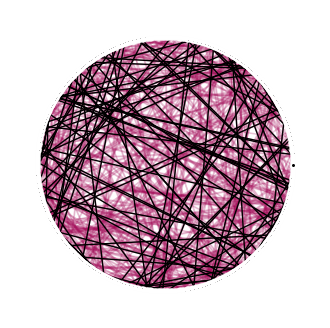

In [314]:
n = 1000
range_k = np.linspace(2, 10, 9)
p = 0.1
sc_ = {}
for k in range_k:
    sc = watts_strogatz_hypergraph(n, int(k), p, p_triangle = 0.9, p_edge = 0.1)
    sc_[(int(k),p)] = sc
    
#plot the hypergraph
f,ax = plt.subplots(1,1,figsize = (4, 4))
plotting.plot_complex(sc,ax = ax,face_color=[colors[2]],layout = "circle", iterations = 1000, node_size=10)
ax.collections[0].set_linewidth(1) 
ax.collections[0].set_edgecolor("#FFFFFF") 


In [329]:
# Define strings which specify the Laplacians to consider

laplacians_types = ["01","02","10","12","20","21"]
#laplacians_types = ["01","02","03","10","12","13","20","21","23","30","31","32"]
#laplacians_types = ["01","02","03","20","21","23","30","31","32"]

# Compute eigenvalues of the Laplacians and their specific heat curves

taumin = -3 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval

sp_heats_ = {}
for k in tqdm(sc_.keys()):
    sp_heats = []
    for l in tqdm(laplacians_types):  
        #print(f"L_({l[0]},{l[1]})")  
        sc = sc_[k]
        L = XO_laplacian_hg(sc, k=int(l[0]), l=int(l[1]))
        D,U = np.linalg.eigh(L)
        D = np.abs(D)

        specific_heat,tau_space, __ = renormalize.compute_entropic_C(D,taumin,taumax,ntau)
        sp_heats.append(specific_heat)
    sp_heats_[k] = sp_heats


100%|██████████| 9/9 [04:39<00:00, 31.04s/it]


(array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 [Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

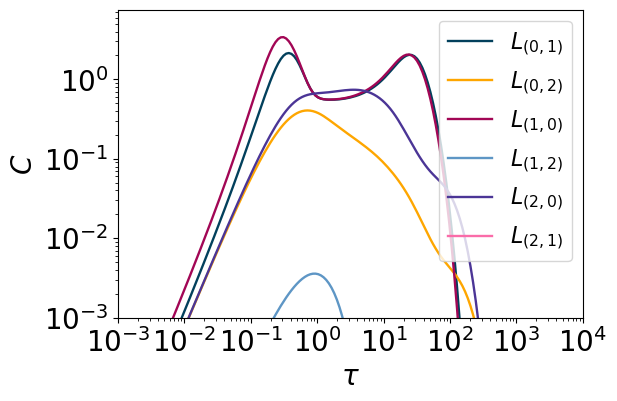

In [271]:
cols  = colors_curves
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))

for i in range(len(laplacians_types)):
    ax.loglog(tau_space,sp_heats[i],linewidth = 1.7,alpha = 1, color = cols[i])


ax.set_ylim([10**-3,7.5])
ax.set_xlim([10**taumin,10**4])

ax.legend([names[i] for i in range(len(laplacians_types))],fontsize = 16)
#ax.legend([f'k = {int(k)}, p = {p}' for k, p in product(range_k, range_p)],fontsize = 8)


ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#ax.vlines(x = 4,ymin = 10**-1,ymax = 0.9,linestyles="--",color = [0.5,0.5,0.5])

#plt.savefig(f"../C_curves/hWS/hWS_{k}.pdf",dpi = 300, bbox_inches = 'tight')

In [330]:
#save simulation
path = '../Experiments_results/hWS_sc.pickle'
with open(path, 'wb') as handle:
    pickle.dump(sc_, handle, protocol=pickle.HIGHEST_PROTOCOL)

path = '../Experiments_results/hWS_spheats.pickle'
with open(path, 'wb') as handle:
    pickle.dump(sp_heats_, handle, protocol=pickle.HIGHEST_PROTOCOL)

9it [00:00, 3301.45it/s]
9it [00:00, 3831.19it/s]


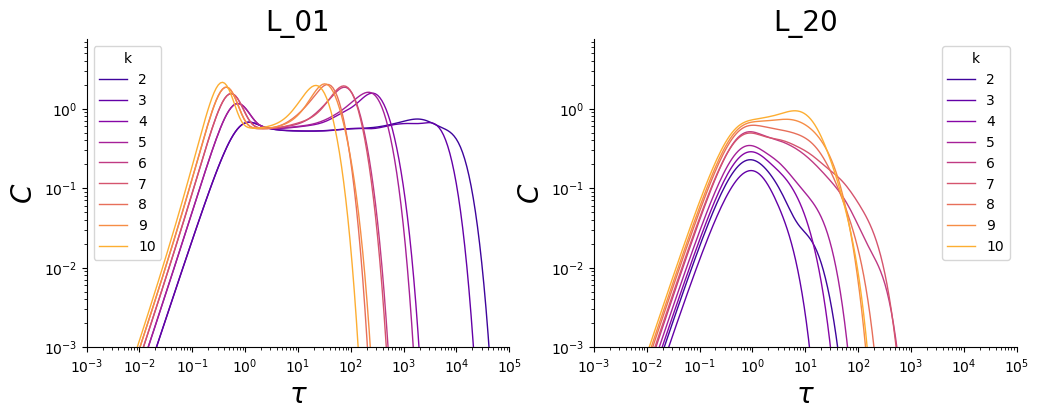

In [370]:

cols  = sns.color_palette("plasma", len(list(L_.keys())))
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,2,figsize = (12,4))
l= [0, 4]
for nk, k in tqdm(enumerate(sp_heats_.keys())):
    sp_heats = sp_heats_[ k ][l[0]]
    ax[0].loglog(tau_space,sp_heats,linewidth = 1,alpha = 1, color = cols[nk])

for nk, k in tqdm(enumerate(sp_heats_.keys())):
    sp_heats = sp_heats_[ k ][l[1]]
    ax[1].loglog(tau_space,sp_heats,linewidth = 1,alpha = 1, color = cols[nk])

for i in range(2):
    ax[i].set_ylim([10**-3,7.5])
    ax[i].set_xlim([10**taumin,10**taumax])

    #ax.legend([names[i] for i in range(len(laplacians_types))],fontsize = 16)
    #ax.legend([f'k = {int(k)}, p = {p}' for k, p in product(range_k, range_p)],fontsize = 8)


    ax[i].set_xlabel(r"$\tau$",fontsize = 20)
    ax[i].set_ylabel(r"$C$",fontsize = 20)
    #ax[i].xticks(fontsize = 20)
    #ax[i].set_yticks(fontsize = 20)

    ax[i].set_title(f'L_{laplacians_types[l[i]]}', fontsize=20)
    ax[i].legend([int(k) for k in range_k],fontsize = 10, title = 'k')
sns.despine()
#ax.vlines(x = 4,ymin = 10**-1,ymax = 0.9,linestyles="--",color = [0.5,0.5,0.5])

plt.savefig(f"../C_curves/hWS/hWS_comparison.pdf",dpi = 300, bbox_inches = 'tight')


(array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 [Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

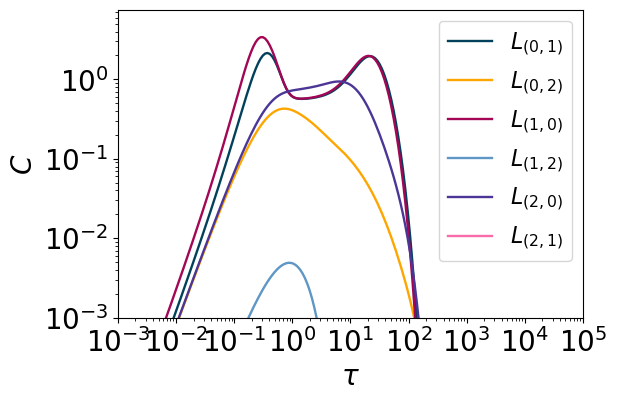

In [344]:

cols  = colors_curves
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))

for i in range(len(laplacians_types)):
    k = (10,0.1)
    sp_heats = sp_heats_[ k ]
    ax.loglog(tau_space,sp_heats[i],linewidth = 1.7,alpha = 1, color = cols[i])


ax.set_ylim([10**-3,7.5])
ax.set_xlim([10**taumin,10**taumax])

ax.legend([names[i] for i in range(len(laplacians_types))],fontsize = 16)
#ax.legend([f'k = {int(k)}, p = {p}' for k, p in product(range_k, range_p)],fontsize = 8)


ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#ax.vlines(x = 4,ymin = 10**-1,ymax = 0.9,linestyles="--",color = [0.5,0.5,0.5])

#plt.savefig(f"../C_curves/hWS/hWS_{k}.pdf",dpi = 300, bbox_inches = 'tight')